## Objective:
<b>My aim throughout this process has been to look at what is common to plays involving concussions in the NGS data and what you can perceive in the videos (empirical approach). From that analysis I choose to propose rule changes that would likely affect the outcome of the punt plays by negating the possibility of certain events or to have rules that would hopefully create a behavioral change in how players partake in the punt play. I lead with my proposed rules and attempt to walk you through why I am proposing these rules.</b>

### Proposed rule changes include:
1. **Allowance of video review of plays where an injury occurs and to allow for subsequent calls of penalties directly related to the injury to be called. If injury isn't apparent immediately and a penalty is thus an unsuitable deterant, a fine may be incurred on the perpetrater of the penalty after a confirmation later by video review (potential overlap with Rule 17 Section 2 Article 3).**
2. **Expanding the defenseless player status to punt team players who are within 5 yards of the PR and are running towards their own endzone (this would be similar to the afforded protection to the punter, Rule 12 Section 2 Article 7-a-8)**
3. **Restricted zone of 8 yards (by yardline) for the punt receiver during play.**
    - Return and punt team players may not be within 8 yards of the PR (by yardline distance) during a punt play unless the PR has signaled for a fair catch, the ball has been caught/muffed by the PR, or the ball has hit the ground.
    - **Penalty**: 10 yards from the PR and the play is called dead when infraction occurs.
    - The fair catch rule could also be removed similar to CFL punt return rules to increase the number of returns, but I believe the number instances where a fair catch would be called is going to be severely reduced because of the restricted zone for the punt returner anyway.

Table of contents:
- [Analysis and Discussion](#aad)
- [Concussion Play and Video Analysis](#cpava)
- [Observations of concussion dataset](#oocd)
- [Observations of concussion film](#oocf)
- [Concussions before the punt](#cbtp)
- [Observations of conussions after the punt](#oocatp)
- [Behavioral Deterrent Rule Changes](#bdrc)
- [Structural Changes to the Punt Return](#scttpr)
- [PR Restricted Zone Analysis](#PR)
- [Overall Rule Coverage of Concussion Related Plays](#coverage)
- [Links to Other Notebooks](#lton)

## <a id='aad'>Analysis and Discussion</a>
My entire process for deriving the above rules comes from viewing the concussion related plays, noting features of those plays I found are distinctive and are directly or indirectly related to the concussion causing event, and understanding the impact of the hypothetical rule change. As we all have seen, the number of concussion events is extremely low (37) and any feature given to us or otherwise derived will likely be used to overfit in any sense to what is contributing to a concussion. **I will also admit I did not particularly focus on ways to reduce the number of punt returns inorder to reduce the number of concussions because punts are already pretty 'uninteresting' at 55.4% of punt plays** resulting in a fair catch, touchback, dead ball, downed ball, no punt, or a kick out of bounds and I was motivated to find ways to potentially increase the number of punt returns while reducing features involved with concussion events. Hopefully the following notebook cells give you an idea of how I came to my conclusions. I also apologize that my analysis spreads out to multiple notebooks, but it made it easier on the memory for the kernels especially with the NGS data.

Just for context I have provided some statistics that were derived in this notebook (https://www.kaggle.com/jdemeo/preprocessing-punt-play) and I may reference occasionally throughout my analysis:
- 3701 of 6681 punt plays are 'uninteresting' (55.4%)
- 2627 of 6681 punt plays result in a punt return (39.3%)
- 353 of 6681 punt plays result in an 'interesting' play other than a punt return (5.3%)
    - Muffs, blocked kicks, fumbles, fake punts, etc.
- 37 of 6681 punt plays result in a concussion (0.55%)

### <a id="cpava">Concussion Play and Video Analysis</a>

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image, display
sns.set()

In [2]:
# Load in concussion data deduced from video review of the play
video_review_df = pd.read_csv('data/video_review.csv')
print(video_review_df.shape)
video_review_df.head(1)

(37, 10)


,Season_Year,GameKey,PlayID,GSISID,Player_Activity_Derived,Turnover_Related,Primary_Impact_Type,Primary_Partner_GSISID,Primary_Partner_Activity_Derived,Friendly_Fire
0,2016,5,3129,31057,Tackling,No,Helmet-to-body,32482,Tackled,No


In [3]:
# Load in player related data
player_df = pd.read_csv('data/player_punt_data.csv')
play_player_role_df = pd.read_csv('data/play_player_role_data.csv')

# Combine Relevant Player Information, Position, Role, Number
master_player_df = pd.merge(player_df, play_player_role_df,
                          how='inner',
                          on=['GSISID']).drop(columns=['Season_Year'])
master_player_df.head()

,GSISID,Number,Position,GameKey,PlayID,Role
0,32069,36,SS,23,2255,PPL
1,32069,36,SS,23,884,PRW
2,32069,36,SS,23,1157,PRW
3,32069,36,SS,23,848,PRW
4,32069,36,SS,23,3065,PPL


In [4]:
# Check summary counts to see if any are needed
print(video_review_df['Player_Activity_Derived'].value_counts())
print('---')
print(video_review_df['Turnover_Related'].value_counts())
print('---')
print(video_review_df['Primary_Impact_Type'].value_counts())
print('---')
print(video_review_df['Primary_Partner_Activity_Derived'].value_counts())
print('---')
print(video_review_df['Friendly_Fire'].value_counts())

where_condition = ((video_review_df['Primary_Partner_GSISID'] == 'Unclear') |
                   (video_review_df['Primary_Partner_GSISID'].isna()))
video_review_df[where_condition]

Tackling    13
Blocked     10
Blocking     8
Tackled      6
Name: Player_Activity_Derived, dtype: int64
---
No    37
Name: Turnover_Related, dtype: int64
---
Helmet-to-body      17
Helmet-to-helmet    17
Helmet-to-ground     2
Unclear              1
Name: Primary_Impact_Type, dtype: int64
---
Blocked     10
Tackling    10
Tackled      8
Blocking     6
Unclear      1
Name: Primary_Partner_Activity_Derived, dtype: int64
---
No         28
Yes         6
Unclear     1
Name: Friendly_Fire, dtype: int64


,Season_Year,GameKey,PlayID,GSISID,Player_Activity_Derived,Turnover_Related,Primary_Impact_Type,Primary_Partner_GSISID,Primary_Partner_Activity_Derived,Friendly_Fire
9,2016,218,3468,28987,Blocked,No,Helmet-to-ground,NaN,NaN,NaN
26,2017,414,1262,33941,Tackling,No,Helmet-to-ground,NaN,NaN,NaN
29,2017,506,1988,27060,Tackled,No,Helmet-to-helmet,NaN,Tackling,No
33,2017,585,733,30384,Blocked,No,Unclear,Unclear,Unclear,Unclear


### <a id="oocd">Observations of concussion dataset</a>
- So we know things involve tackling and blocking (you need contact of some sort to have a concussion)
- We see no plays resulted in a turnover.
- We can see the majority of concussions are related to a helmet hitting some other mass minus the one 'unclear' instance
- Majority of concussions are not a result of friendly fire
- There are 4 plays that have no designated primary_partner: two were helmet-to-ground, 1 was unclear, and 1 was helmet to helmet (H2H).
    - If you review those two latter videos, the 'unclear' designation was a clear helmet to the back of the head of #44 by Houston Player #55/56 (not sure of number; could probably verify with GSISID from NGS data for the play) and for the H2H you can see Dolphins #34 make a diving head tackle on Baltimore #21.
        - This information you can deduce by looking at the play video

In [5]:
# Now that we have a descriptive idea of what's going on, I'm gonna just drop these columns
# and also clear up the unclear designation and convert it to NaN
droppers = ['Player_Activity_Derived', 'Turnover_Related', 'Primary_Partner_Activity_Derived', 
            'Friendly_Fire', 'Season_Year']
video_review_df.drop(columns=droppers, inplace=True)

# Remove 'Unclear' designation
video_review_df.loc[33, 'Primary_Partner_GSISID'] = 'NaN'

#### VIDEO FOOTAGE

In [6]:
'''Concussion Video Footage'''
video_footage_injury_df = pd.read_csv('data/video_footage-injury.csv')
print(video_footage_injury_df.shape)
video_footage_injury_df.head(1)

(37, 10)


,season,Type,Week,Home_team,Visit_Team,Qtr,PlayDescription,gamekey,playid,PREVIEW LINK (5000K)
0,2016,Pre,2,Chicago Bears,Denver Broncos,3,(3:44) (Punt formation) P.O'Donnell punts 58 y...,5,3129,http://a.video.nfl.com//films/vodzilla/153233/...


In [7]:
# Preprocess to allow for easier joins
rename_columns = {'gamekey': 'GameKey', 'playid': 'PlayID', 'season': 'Season_Year'}
video_footage_injury_df.rename(columns=rename_columns, inplace=True)

# Combine Video Review and Video Injury DataFrames to have the injured player and partner player data
injury_play = pd.merge(video_review_df, video_footage_injury_df, 
                       how='inner', 
                       on=['GameKey', 'PlayID'])

# Lets Drop Some More Data I consider uncritical for getting a feel for the data
droppers = ['Season_Year', 'Type', 'Week', 'Home_team', 'Visit_Team', 'Qtr']
injury_play.drop(columns=droppers, inplace=True)

injury_play.head(1)

,GameKey,PlayID,GSISID,Primary_Impact_Type,Primary_Partner_GSISID,PlayDescription,PREVIEW LINK (5000K)
0,5,3129,31057,Helmet-to-body,32482,(3:44) (Punt formation) P.O'Donnell punts 58 y...,http://a.video.nfl.com//films/vodzilla/153233/...


In [8]:
# Join Info (their jersey number, position, role) on the concussed player
injury_play = pd.merge(injury_play, master_player_df,
                           how='inner',
                           on=['GSISID', 'GameKey', 'PlayID'])

print('Shape:', injury_play.shape)
injury_play.head(1)

Shape: (58, 10)


,GameKey,PlayID,GSISID,Primary_Impact_Type,Primary_Partner_GSISID,PlayDescription,PREVIEW LINK (5000K),Number,Position,Role
0,5,3129,31057,Helmet-to-body,32482,(3:44) (Punt formation) P.O'Donnell punts 58 y...,http://a.video.nfl.com//films/vodzilla/153233/...,25,RB,PLW


I get the concussed player's information to identify their jersey number in the video. With potentially multiple jersey numbers associated with a player, this was needed information to focus on what events led up to the concussion. I watched the film and cross referenced plays where it was unclear as to the players number with game recaps (googled) to identify the concussed players number.

In [9]:
# Drop Certain Rows After Identifying Concussed Players Jersey Number from video
drop_rows = [1, 7, 17, 20, 23, 26, 27, 28, 29, 32, 33, 36, 38, 39, 45, 46, 47, 50, 52, 55, 57]
injury_play.drop(labels=drop_rows, inplace=True)
injury_play.reset_index(drop=True, inplace=True)

# Convert Primary_Partner_GSISID from str to float
injury_play['Primary_Partner_GSISID'] = injury_play['Primary_Partner_GSISID'].astype('float')
injury_play.shape

(37, 10)

So from this point I view the films and begin noting features I found important for my analysis or that I thought were indirecty/directly related to a concussion event.

### <a id="oocf">Observations of concussion film</a>
- Many concussions look to be very bang-bang in nature, that is a **play progresses quickly from one impact to another**
- I noticed that many players who were concussed were in situations where they had **little to no time to anticipate or brace for a particular impact**
- I also noticed that the result of some concussions were aided by some **illegal action** (blindside block/tackle on defenseless player, illegal block above the waist, low block) that was not flagged for a particular play 
    - **It's also very notable that every one of these uncalled penalties was executed by the return team**
    - This is all from my un-expert opinion and I will be labeling some plays based on illegal actions in subsequent analysis
- The new (2018) **use-of-helmet rule** would apply to many of the plays in this dataset so I also label these cases
    - https://operations.nfl.com/the-rules/2018-rules-changes-and-points-of-emphasis/
    - https://operations.nfl.com/the-rules/nfl-video-rulebook/use-of-the-helmet/
- The vast majority of concussions are occuring after the ball is punted and after the ball is received

After viewing the the concussion films multiple times, I hand labeled and categorized the films based on specific film attributes from my observations above.

In [10]:
# 0 = No, 1 = Yes, 2 = inconclusive
# When concussions are occuring
after_ball_punted = [1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1]
after_punt_received = [1,0,1,1,1,0,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1]
fake = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# My un-expert labeling for uncalled penalties and where the new use-of-helmet rule would apply
uncalled_penalty = [2,0,2,0,1,0,0,1,0,1,1,0,0,0,0,0,1,2,0,0,1,1,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0]
helmet_rule = [1,1,1,1,0,0,0,0,1,0,1,1,1,0,0,1,2,0,1,1,1,0,1,0,0,0,0,0,0,1,1,1,1,1,0,1,0]

In [11]:
# Add one hot encodings
injury_play['after_ball_punted'] = after_ball_punted
injury_play['after_punt_received'] = after_punt_received
injury_play['fake'] = fake
injury_play['uncalled_penalty'] = uncalled_penalty
injury_play['helmet_rule'] = helmet_rule
injury_play.to_csv('data/injury_play.csv', index=False)

Created **'injury_play.csv'** to be used in notebook: https://www.kaggle.com/jdemeo/analysis-uncalled-penalties

---
### <a id="cbtp">Concussions before the punt</a>
I wanted to add explicitly that I do not address the concussions **(4 of 37)**  that were at the line of scrimmage or of the fake pyend beyond my statements below:
- **(60, 905)**: The bull rush results in H2H contact, where the punt team PRW leads with his helmet, the new **use-of-helmet rule** may apply in this scenario.
- **(274, 3609)**: The fake punt doesn't seem preventable and was an unfortunate circumstance
- **(280, 2918)**: The punt team PLW is either slipping and hits his helmet into knee of return team player or is executing an illegal low block. I think he is more slipping than anything and is an unfortunate circumstance.
- **(607, 978)**: Return team player has slight lead with his helmet onto the punt teams PLW's helmet. I wouldn't say the use-of-helmet applies because the return team player leads with his hands. Again this is an unfortunate circumstance and I don't think is preventable.
- **As a suggestion, it should be emphasized to players in the tackle box to make better use of leading with their hands on punt plays**
    - Just an aside, It would be interesting to see how often players are banging heads on such plays relative to normal offensive plays.
---

In [12]:
columns_of_interest = ['after_punt_received', 'uncalled_penalty', 'helmet_rule']
for column in columns_of_interest:
    print(injury_play[injury_play['after_ball_punted'] == 1][column].value_counts())
    print('---')

1    31
0     2
Name: after_punt_received, dtype: int64
---
0    20
1     9
2     4
Name: uncalled_penalty, dtype: int64
---
1    18
0    14
2     1
Name: helmet_rule, dtype: int64
---


### <a id="oocatp">Observations of concussions after the punt:</a>
All future analysis focuses on concussions that occured after the punt **(33 of 37)**
- Notable features
    - Only **2** of these punt plays had a concussion occur before the punt was received
    - There were **9 uncalled penalties, all of which were executed by the return team** that resulted in a players concussion
        - **4 plays** were inconclusive because the video does not show enough of the play to come to a conclusion
    - There were **18** punts where the new **use-of-helmet rule** would likely apply
 
### <a id="bdrc">Behavioral Deterrent rule changes</a>
Of these features, one area I focused attention was on the **uncalled penalties** that directly resulted in a players concussion. It is important to reduce unnecessary and illegal behavior that may be directly related to a concussion event or any injury related play. Any prevention of concussions will have to be behavioral (change to how a player plays) or a restructuring of a particular play (touchback rules, allowable distances between players, etc.). The below two proposed rules aim to be deterrants for unnecessary behavior. I reference my notebook here (https://www.kaggle.com/jdemeo/analysis-uncalled-penalties) for my reasoning of the below two rules as well as a short discussion of their potential impact to the game:
1. **Allowance of video review of plays where an injury occurs and to allow for subsequent calls of penalties directly related to the injury to be called. If injury isn't apparent immediately and a penalty is thus an unsuitable deterant, a fine may be incurred on the perpetrater of the penalty after a confirmation later by video review (potential overlap with Rule 17 Section 2 Article 3).**
2. **Expanding the defenseless player status to punt team players who are within 5 yards of the PR and are running towards their own endzone (this would be similar to the afforded protection to the punter, Rule 12 Section 2 Article 7-a-8)**
---

### <a id="scttpr">Structural Change to the Punt Return</a>
In a previous notebook (https://www.kaggle.com/jdemeo/nfl-concussion-video-analysis) I looked at the speed of the concussed player and the primary partner involved in the concussion, to get a better idea of the speeds at which concussions occurred. Players were at times reaching speeds faster than the average speeds of the top 40-yard dash runners. Also a number of the concussions were occurring very close the PR. From the gist of that, I wanted to consider ways to reduce the speeds at which players could potentially be playing at in hopes that could reduce high speed collisions as well as allow for more time for a players decision making and anticipation of how a play will unfold especially for the punt receiver. 

As for a fun hypothetical I considered the Canadian Football Leagues rules for punt returns. In the CFL, essentially a PR is given a 5 yard buffer (as long as the punt is still in the air) against any opponent player to allow for receiving the punt or else a "no yards" penalty of 5 or 15 yards is given depending on the circumstance and there is no option for a fair catch (example of penalty: https://www.cfl.ca/2018/06/20/football-operations-video-series-week-1-no-yards-interference/). As, I looked at more film of this type of penalty and looked deeper into how such a rule would hypothetically affect concussion related punts, punt returns, and fair catches over the 2016 and 2017 NFL seasons, it became more reasonable to me to make a proposal. The proposed rule change:

3. **Restricted zone of 8 yards (yardline distance) for PR during play.**
    - Return and punt team players may not be within 8 yards of the PR (by yardline distance) during a punt play unless the PR has signaled for a fair catch, the ball has been caught/muffed by the PR, or the ball has hit the ground.
    - **Penalty**: 10 yards from the PR and the play is called dead when infraction occurs.
    - The fair catch rule could also be removed similar to CFL punt return rules to increase the number of returns, but I believe the number instances where a fair catch would be called is going to be severely reduced because of the restricted zone for the punt returner anyway.
    
<img src="https://i.imgur.com/NfkRtPP.png"/>

Now how did I come to this reasoning? I particularly look at the proximity of the **closest punt team player to the PR at the time of a particular event** (most often when the punt is received; varies with regards to the concussion data). Looking at this attribute for concussion plays, fair catches, and returned punts gives me a framework for considering the affect of a restricted zone. Essentially I am looking to see well, if this restricted zone existed, how many concussion related plays would have been affected by this rule and possibly have negated the concussion. Let's say we want to cover half of those concussions in hopes to prevent them by this restructuring of the punt play. Well given that restricted zone distance how many punt returns would have been negated? What was the average yardage gained for punt returns that would be negated? Is the penalty then more favorable then that yardage gained? What's the average yardage gained for returns that are not affected by this penalty? Does the penalty balance the risk reward for the punt team and return team? Would fair catches still be called?

I know alot of questions, but this was my thought process and my notebooks are a bit spread out so I wanted to present these questions and answer them directly below. You can go through my notebooks to see additional reasoning for an 8 yard restricted zone for the PR, but hopefully I can sufficiently distill my analysis and conclusions here.

Quick notes: 
- **yardline distance** is the distance between two players by the yardline they are at (ex: player_1 is at 10 yardline, player_2 is at 15 yardline, yardline_distance = 5)
- **Euclidean distance** is the shortest path distance between the two players
- **All proximities are that of the closest punt team player to the punt receiver at time of catch**
- **Reward** is a proportional metric defined as: number of yards gained on the return / total yards needed for touchdown
    - This was calculated to have a standardized value for the value of a return
---

### <a id='PR'>PR Restricted Zone Analysis</a>
So that you don't have to get to the end of this notebook, I am gonna tell you that on average **concussions are occurring on plays where the closest punt team player is within 8.1 yards in the x-direction from the PR or 9.7 yards in euclidean distance from the PR at the time the ball has landed after the punt** ([skip to histogram](#concussion_proximity)). So if we run with the hypothetical and want to cover half of the concussion plays we'd need a restricted zone of 8 yards by yardline distance and 10 yards by Euclidean distance to cover 17 of 33 concussions.

Given this restricted zone distance how many punt returns would have been negated? What was the average yardage gained for punt returns that would be negated? Is the penalty then more favorable then that yardage gained? 

Analysis of punt returns: https://www.kaggle.com/jdemeo/analysis-punt-returns

- Summary
    - **2604** punt returns were analyzed
    - **Average proximity by yardline distance: 9.17 yards**
    - **Average proximity by Euclidean distance: 11.04 yards**
    - Hypothetical Restricted Zones:
        - Given that the closest punt team player is less than or equal to 8 yards (yardline distance) from PR at time of catch:
            - Count: **1216**
            - **Average yards gained by PR on play: 8.01 yards**
            - **Average reward by PR on play: 0.11**
        - Given all punt team players are greater than 8 yards (yardline distance) from PR at time of catch:
            - Count: **1388**
            - **Average yards gained by PR on play: 11.71 yards**
            - **Average reward by PR on play: 0.15**
        - So we are looking at an average difference of 3.70 yards between the two distributions.
        - Given that the closest punt team player is less than or equal to 10 yards (Euclidean distance) from PR at time of catch:
            - Count: **1205**
            - **Average yards gained by PR on play: 7.91 yards**
            - **Average reward by PR on play: 0.11**
        - Given all punt team players are greater than 8 yards (Euclidean distance) from PR at time of catch:
            - Count: **1399**
            - **Average yards gained by PR on play: 11.76 yards**
            - **Average reward by PR on play: 0.16**
        - So we are looking at an average difference of 3.85 yards between the two distributions.
        - I present two hypothetical restricted zone distances to only show that they are nearly equivalent. It's just much easier to know 8 yards by yardline distance then 10 yards by Euclidean distance because of the fields painted yardline markers.
    - **So intuitively the further the closest punt team player is from the PR at the time of the catch, the higher the mean return distance and 'reward' value for return.**

Now why a restricted zone distance of 10 yards (Euclidean) or 8 yards (yardline)? Well if you plot the difference between means of each pair of distributions given a restricted zone distance you reach a minimum around 8-10 yards by Euclidean distance. This esssentially says that a restricted zone of greater size than this does not change the difference of average yards gained between the distributions. So by choosing a restricted zone of this size, we are able to affect or hopefully prevent at least half of the concussion events (as those plays would end up being called dead by penalty or the play would slow down from the restricted zone) and the restricted zone is at about the size where the difference in returns from plays where the penalty would be called and not be called would no longer benefit from a larger restricted zone with respect to yards gained on return .

<img src="https://i.imgur.com/rBITQx3.png"/>
    
    
Now we make the assumption well what happens if we implemented this rule, what affect does it have on the data thats given for the two seasons. This can give us an idea of gains and losses to the game we would have. 

---

Players who are given essentially a buffer of at least 8 yards (yardline) at time of catch are gaining on average **3.7 more yards** than folk who have at least one punt team player in this buffer zone. But under the proposed rule, we'd be **flagging/negating 1216 punt returns**. Man the punt got real boring... But the return team would be gaining on average **2.0 more yards on those particular events** (10 yard penalty - 8.01 yard return average) so I guess that's exciting depending what team you're rooting for. How are we going to make up losing this many plays? Well let's look at the fair catch. 
- **You could also just stop here if you wanted to reduce the number of punt returns to prevent concussions on the punt. Although, this 1216 flagged number would decrease significantly as players would learn to not incur this penalty at the assumed 100% frequency.**

Analysis of fair catches: https://www.kaggle.com/jdemeo/analysis-fair-catches
- Don't forget: All proximities are that of the closest punt team player to the punt receiver at time of catch
- Summary:
    - **1637** fair catches were analyzed
    - Average proximity by yardline distance: 2.72 yards
    - Average proximity by Euclidean distance: 4.04 yards
    - **~5% or ~85 of all fair catches** occur when all punt team players are greater than 8 yards by yardline distance and 10 yards by Euclidean distance from the PR
    - Graphic of punt return and fair catch proximity distributions by yardline distance:
    
<img src="https://i.imgur.com/0Q40fz9.png"/>
    
So now the next question is well if this restricted zone existed, how many fair catches would have been actually called? Given that **5% of all fair catches (~85 of 1637) were called outside of the proposed restricted zone** distance, I would suspect that the other 95% would be more likely to try a punt return. Let's just say that **95% chooses a punt return** instead just to stay in line with the the above punt return assumptions and negations. We now have **1552 more punt returns** and still would have 85 fair catches given the proposed rule.

Now we are looking at an increase of **336 more punt returns** (1552 - 1216), which brings the **count of interesting plays to 3316 total (49.6% of plays)**. I believe this is also on the conservative end since we assume punt team players do not change their behavior at all and will incur the restricted zone penalty in the case of punt returns. We were also generous with how many PRs would actually attempt the punt return instead of still taking the fair catch, which would lower the estimated increase in number of punt returns. 

So the game got a bit more interesting and we've **eliminated features of 17 of 33 concussions** that occur after the punt. [If you click on this, you'll jump down to my summary of counts of coverage between the NFL's use-of-helmet rule, uncalled penalty rules, and PR restricted zone rule](#coverage). Essentially those 3 **rules would affect 29 of 33 concussion related plays** by being deterrants to certain actions or eliminating features entirely that are associated with these plays. Thanks for taking the time if you got this far along. I'll have a far more condensed rendition in my summary/presentation slides. **Remember safety first, then teamwork** Cheers! 

<img src="https://i.imgur.com/U1z4GGZ.png"/>

---

The rest of the notebook goes over analysis of the concussion plays with use of the NGS dataset.

### CONCUSSION PLAY ANALYSIS
- <b>Next Gen Stats</b>: player level data that describes the movement of each player during a play. NGS data is processed by BIOCORE to produce relevant speed and direction data. The NGS data is identified using GameKey, PlayID, and GSISID. Player data for each play is provided as a function of time (Time) for the duration of the play.
- Players are recorded at every <b>10th of a second or 100 milliseconds</b>
- Field dimensions: 120 yards by 53.3 yards
- Speed can be calculated with Time and dis
- <b>Event</b> records essentially game states ('line_set', 'punt', 'punt_received', etc.)
- **NGS-concussion.csv** can be obtained from : https://www.kaggle.com/jdemeo/preprocessing-ngs

In [14]:
# Load in NGS data, player role data, and play info
ngs_concussion = pd.read_csv('data/NGS-concussion.csv')
play_player_role_df = pd.read_csv('data/play_player_role_data.csv')
play_df = pd.read_csv('data/play_information.csv')

# Merge datasets
ngs_concussion = pd.merge(ngs_concussion, play_player_role_df,
                  how="inner",
                  on=['GameKey', 'PlayID', 'GSISID'])

ngs_concussion = pd.merge(ngs_concussion, play_df,
                  how="inner",
                  on=['GameKey', 'PlayID'])

# Cleanup
keepers = ['GameKey', 'PlayID', 'GSISID', 'Time', 'x', 'y', 'dis', 'Event', 'Role', 'PlayDescription']
ngs_concussion = ngs_concussion[keepers]
ngs_ids = ngs_concussion.groupby(['GameKey','PlayID']).size().reset_index().rename(columns={0:'count'})
print('Number of unique plays in NGS dataset:', ngs_ids.shape[0])
ngs_concussion.head()

Number of unique plays in NGS dataset: 37


,GameKey,PlayID,GSISID,Time,x,y,dis,Event,Role,PlayDescription
0,5,3129,31130.0,2016-08-12 02:07:26.300,80.540001,25.969999,0.06,NaN,PLG,(3:44) (Punt formation) P.O'Donnell punts 58 y...
1,5,3129,31130.0,2016-08-12 02:07:26.400,80.559998,25.920000,0.05,NaN,PLG,(3:44) (Punt formation) P.O'Donnell punts 58 y...
2,5,3129,31130.0,2016-08-12 02:07:26.500,80.580002,25.879999,0.04,NaN,PLG,(3:44) (Punt formation) P.O'Donnell punts 58 y...
3,5,3129,31130.0,2016-08-12 02:07:26.600,80.589996,25.850000,0.03,NaN,PLG,(3:44) (Punt formation) P.O'Donnell punts 58 y...
4,5,3129,31130.0,2016-08-12 02:07:26.700,80.580002,25.840000,0.01,NaN,PLG,(3:44) (Punt formation) P.O'Donnell punts 58 y...


In [15]:
# Filter for after_punt concussions
where_condition = (injury_play['after_ball_punted'] == 1)
after_punt_df = injury_play[where_condition]
after_punt_df.reset_index(inplace=True, drop=True)
after_punt_ids = after_punt_df.groupby(['GameKey','PlayID']).size().reset_index().rename(columns={0:'count'})

# Get appropriate NGS data
ngs_after_punt = pd.merge(ngs_concussion, after_punt_ids,
                          how='inner',
                          on=['GameKey', 'PlayID'])

### Calculating Proximity to PR upon Catch

In [16]:
'''ONLY RUN THE FOLLOWING TWO BLOCKS TO GET AN IDEA OF THE COURSE OF EVENTS FOR A PARTICULAR PLAY'''

# def isolate_play(df, game_key, play_id):
#     '''Create a dataframe of a particular play'''
#     where_condition = ((df['GameKey'] == game_key) &
#                        (df['PlayID'] == play_id))
#     new_df = df[where_condition].copy()
#     new_df.sort_values(by=['Time'], inplace=True)
#     new_df.reset_index(drop=True, inplace=True)
#     return new_df

# def course_of_events(df):
#     '''Get list of events in order of occurrence for a particular play'''
#     events = []
#     for i in range(len(df)):
#         event = df.loc[i, 'Event']
#         if event not in events:
#             events.append(event)
           
#     print('Play Description:', df.loc[0, 'PlayDescription'])
#     print('')
#     print('Game Events:', events)
#     print('-----------------------------------------------')

'ONLY RUN THE FOLLOWING TWO BLOCKS TO GET AN IDEA OF THE COURSE OF EVENTS FOR A PARTICULAR PLAY'

In [17]:
# # Iterate through ids to get events for each play
# def whats_going_on(df, ids):
#     for i in range(len(ids)):
#         game_key = ids.loc[i, 'GameKey']
#         play_id = ids.loc[i, 'PlayID']
#         print('(', game_key, ',', play_id, ')')
#         the_play = isolate_play(df, game_key, play_id)
#         course_of_events(the_play)
        
# whats_going_on(ngs_after_punt, after_punt_ids)

- So the events where the ball is caught or hits the turf include: 'punt_received', 'punt_downed', 'kick_received', 'punt_land'
- We will look at the proximity of punt team players to the PR at these events in the NGS dataset
    - Proximities include just the yardline distance ('x') or Euclidean distance ('circle')
        - **When I yardline distance I am talking about the distance from one players position to anothers by the yardline. So if player_1 is at the 10 yardline and player_2 is at the 12 yardline, their x-distance from each other is 2 yards.**
        - **Actual distance is the euclidean distance (straight-line distance) between player_1 and player_2**
    - Both are considered because implementing a rule that is based on yard distances is easier to gauge when its by the yardline versus the shortest distance between two players

In [18]:
def event_df_creation(df, event):
    '''Get a new dataframe with data pertinent to a particular event'''
    new_df = df[df['Event'] == event].reset_index(drop=True)
    unique_ids = new_df.groupby(['GameKey','PlayID']).size().reset_index().rename(columns={0:'count'})
    return new_df, unique_ids

In [19]:
# Let's indicate what team the player is playing on based off player role
return_team_positions = ['PR', 'PDL1', 'PDL2', 'PDL3', 'PDL4', 'PDR1', 'PDR2', 'PDR3', 'PDR4', 'VL', 'VR', 
                         'PLL', 'PLR', 'VRo', 'VRi', 'VLi', 'VLo', 'PLM', 'PLR1', 'PLR2', 'PLL1', 'PLL2',
                         'PFB', 'PDL5', 'PDR5', 'PDL6', 'PLR3', 'PLL3', 'PDR6', 'PLM1', 'PDM']
punt_team_positions = ['P', 'PLS', 'PPR', 'PLG', 'PRG', 'PLT', 'PRT', 'PLW', 'PRW', 'GL', 'GR',
                       'GRo', 'GRi', 'GLi', 'GLo', 'PC', 'PPRo', 'PPRi', 'PPL', 'PPLi', 'PPLo']

def label_team(df):
    '''Label each player by the team they play on'''
    df['team'] = ''

    for i, role in enumerate(df['Role']):
#         print(i, role)
        if role in return_team_positions:
            df.loc[i, 'team'] = 'return team'
        elif role in punt_team_positions:
            df.loc[i, 'team'] = 'punt team'
        else:
            df.loc[i, 'team'] = 'unknown'

In [20]:
def calculate_player_proximity(role_x, role_y, player_x, player_y):
    '''Calculate distance of a player to a particular role'''
    leg_x = (role_x - player_x) ** 2
    leg_y = (role_y - player_y) ** 2
    hypotenuse = np.sqrt(leg_x + leg_y)
    return hypotenuse

In [21]:
def calculate_x_proximity(role_x, player_x):
    '''Calculate distance of a player to a particular role only by yardline'''
    return np.abs(role_x - player_x)

In [22]:
def calculate_proximity_for_play(df, unique_ids, role):
    '''Calculate proximity of each player to the player of a particular role'''
    # Create feature for player proximity
    df['proximity_to_' + role + '_circle'] = 0
    df['proximity_to_' + role + '_x'] = 0
    
    # Go through each data point in particular NGS dataset
    for i in range(len(df)):
#         print(i)
        
        # Play Information
        game_key = df.loc[i, 'GameKey']
        play_id = df.loc[i, 'PlayID']
        
        # Get one unique set of data points related to a single (GameKey, PlayID) pair
        where_condition = ((df['GameKey'] == game_key) &\
                           (df['PlayID'] == play_id))
        just_view = df[where_condition].reset_index()
        
        # Get coordinates of a player with a particular role
        if any(just_view['Role'] == role):
            role_x = just_view.loc[just_view['Role'] == role, 'x'].values[0]
            role_y = just_view.loc[just_view['Role'] == role, 'y'].values[0]
            
        # Plays that don't actually have the particular role represented
        else:
            continue

        # Current Player coordinates
        position_x = df.loc[i, 'x']
        position_y = df.loc[i, 'y']

        # Calculate proximity
        proximity_hypo = calculate_player_proximity(role_x, role_y, position_x, position_y)
        proximity_x = calculate_x_proximity(role_x, position_x)
        df.loc[i, 'proximity_to_' + role + '_circle'] = proximity_hypo
        df.loc[i, 'proximity_to_' + role + '_x'] = proximity_x
        
    # Calculate closest player (adds to ids dataframe)
    calculate_closest_player(df, unique_ids, 'proximity_to_' + role + '_circle')
    calculate_closest_player(df, unique_ids, 'proximity_to_' + role + '_x')

In [23]:
def calculate_closest_player(df, unique_ids, column):
    '''Find who the closest player on the punt team and create new id set'''
    unique_ids[column] = 0
    good_indexes = []
    
    for i in range(len(unique_ids)):
#         print(i)
        
        # Play information
        game_key = unique_ids.loc[i, 'GameKey']
        play_id = unique_ids.loc[i, 'PlayID']

        # Get one unique set of data points related to a single (GameKey, PlayID) pair
        where_condition = ((df['GameKey'] == game_key) &\
                           (df['PlayID'] == play_id) &\
                           (df['team'] == 'punt team'))
        just_view = df[where_condition].reset_index(drop=True)
        
        # Take minimum of series and Error handling where the NGS data had no punt team :(
        try:
            unique_ids.loc[i, column] = min(just_view[column])
            good_indexes.append(i)
        except ValueError:
            continue

In [24]:
def all_event_proximities(ngs_df, events):
    data_frames = []
    
    for event in events:
        event_df, event_ids = event_df_creation(ngs_df, event)
        label_team(event_df)
        calculate_proximity_for_play(event_df, event_ids, 'PR')
        data_frames.append(event_ids)
        
    # Combine ids of particular play events
    new_ids = pd.concat(data_frames,
                        axis=0)
    new_ids.reset_index(inplace=True, drop=True)
    
    return new_ids

In [25]:
# Events of interest
events = ['punt_received', 'punt_downed', 'kick_received', 'punt_land']

new_ids = all_event_proximities(ngs_after_punt, events)
new_ids.head()

,GameKey,PlayID,count,proximity_to_PR_circle,proximity_to_PR_x
0,5,3129,22,17.316649,16.419998
1,29,538,22,4.798677,4.279999
2,45,1212,22,3.713031,2.790001
3,54,1045,22,10.337241,10.309998
4,144,2342,22,12.411482,7.680000


- We now have the closest proximity of a punt player to the PR when the ball is caught, downed, or lands so let's look at the distribution of this set.
- Remember: x = yardline distance, circle = euclidean distance

In [26]:
'''Plot of distribution distance of closest player to punt receiver'''
def proximity_distribution(df, column):
    bins = [i for i in range(0, 30, 1)]
    plt.hist(df[column], bins=bins)

    plt.title(column)
    plt.xlabel('Yards')
    plt.ylabel('count')
    plt.show()

    print(new_ids[column].describe())

[Back to PR Restricted Zone Analysis](#PR)
#### <a id='concussion_proximity'>Concussion Proximity</a>

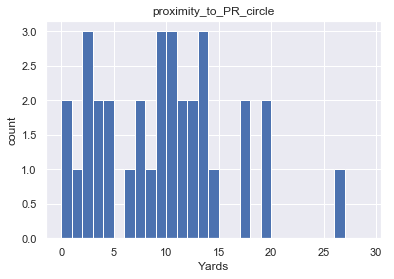

count    33.000000
mean      9.698254
std       6.167227
min       0.094337
25%       4.007398
50%       9.930081
75%      13.466461
max      26.229712
Name: proximity_to_PR_circle, dtype: float64


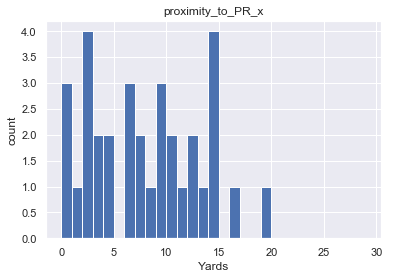

count    33.000000
mean      8.069091
std       5.215547
min       0.049995
25%       3.470001
50%       7.920002
75%      12.329998
max      19.600002
Name: proximity_to_PR_x, dtype: float64


In [30]:
proximity_distribution(new_ids, 'proximity_to_PR_circle')
proximity_distribution(new_ids, 'proximity_to_PR_x')

In [31]:
# Number of concussion plays affected by a rule with 8 yard restricted zone for PR by yardline distance
print(new_ids[new_ids['proximity_to_PR_x'] <= 8].shape[0])

# Number of concussion plays affected by a rule with 10 yard restricted zone for PR by euclidean distance to PR
print(new_ids[new_ids['proximity_to_PR_circle'] <= 10].shape[0])

17
17


- We can see on average **concussions are occurring on plays where the closest punt team player is within 8.1 yards in the x-direction from the PR or 9.7 yards in euclidean distance from the PR at the time the ball has landed after the punt.**
- Obviously this isn't a normal distribution, but we can see that more than half of concussions are occuring with a yardline distance less than 8 yards (17 of 33) or less than 10 yards euclidean distance (17 or 33) when this type of feature is present during the punt play.
- I believe this restricted zone could have helped to prevent these concussions, by forcing players to slow their pursuit of the PR and be more aware of their positioning relative to the PR.
- I also must note that many of the concussions could have potentially been prevented by the implementation of the new 'use of helmet' rule. You may have noticed I had one-hot encoded the concussion plays where I believe the 'use of helmet' rule could have changed the behavior of the player invovled in the concussion.
    - https://operations.nfl.com/the-rules/2018-rules-changes-and-points-of-emphasis/
    - https://operations.nfl.com/the-rules/nfl-video-rulebook/use-of-the-helmet/
- The below script is to just find where the PR restricted zone and helmet rule would have overlapped to understand the 'coverage' of these rules for the concussions involved in this dataset.

## <a id="coverage">Overall Rule Coverage of Concussion Related Plays</a>

In [32]:
# Combine with injury_play data to get one-hot encoding labels
combo = pd.merge(new_ids, after_punt_df,
                 how="inner",
                 on=['GameKey', 'PlayID'])

# Get Number of concussions that a particular rule may pertain too
print('Concussion Coverage by Particular Rules')
print('---------------------------------------')
print('Count of use-of-helmet rule:', combo[combo['helmet_rule'] == 1].shape[0])
print('Count of uncalled penalty rules:', combo[combo['uncalled_penalty'] == 1].shape[0])
print('Count of PR restricted zone rule:', combo[combo['proximity_to_PR_x'] <= 8].shape[0])

# Get overlap of rule counts
where_condition_1 = ((combo['helmet_rule'] == 1) &
                    (combo['uncalled_penalty'] == 1))
where_condition_2 = ((combo['helmet_rule'] == 1) &
                    (combo['proximity_to_PR_x'] <= 8))
where_condition_3 = ((combo['uncalled_penalty'] == 1) &
                    (combo['proximity_to_PR_x'] <= 8))
where_condition_4 = ((combo['proximity_to_PR_x'] <= 8) &
                    (combo['helmet_rule'] == 1) & 
                    (combo['uncalled_penalty'] == 1))

print('Count for use-of-helmet and uncalled penalty rules:', combo[where_condition_1].shape[0])
print('Count for use-of-helmet and PR restricted zone rules:', combo[where_condition_2].shape[0])
print('Count for uncalled penalty and PR restricted zone rules:', combo[where_condition_3].shape[0])
print('Count for use-of-helmet, uncalled penalty, and PR restricted zone rules:', combo[where_condition_4].shape[0])

Concussion Coverage by Particular Rules
---------------------------------------
Count of use-of-helmet rule: 18
Count of uncalled penalty rules: 9
Count of PR restricted zone rule: 17
Count for use-of-helmet and uncalled penalty rules: 2
Count for use-of-helmet and PR restricted zone rules: 11
Count for uncalled penalty and PR restricted zone rules: 2
Count for use-of-helmet, uncalled penalty, and PR restricted zone rules: 0


- Total concussions occuring after the punt: 33
- These threes rules cover <b>29 of 33</b> concussions that occur after the punt

In [41]:
from matplotlib_venn import venn3, venn3_circles

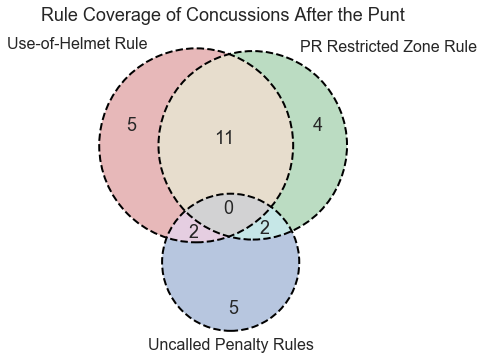

In [59]:
# Make the diagram
plt.figure(figsize=(10, 6))
labels = ['Use-of-Helmet Rule', 'PR Restricted Zone Rule', 'Uncalled Penalty Rules']
v = venn3(subsets = (5, 4, 11, 5, 2, 2, 0), set_labels=labels, )
c = venn3_circles(subsets = (5, 4, 11, 5, 2, 2, 0), linestyle='dashed')

for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(18)
plt.title('Rule Coverage of Concussions After the Punt', fontsize=18)
plt.savefig('figures/venn_diagram.png', bbox_inches='tight')
plt.show()

# <a id="lton">Links to other notebooks</a>:
- Analysis of uncalled penalties: https://www.kaggle.com/jdemeo/analysis-uncalled-penalties
- Analysis of punt returns: https://www.kaggle.com/jdemeo/analysis-punt-returns
- Analysis of fair catches: https://www.kaggle.com/jdemeo/analysis-fair-catches
- Preprocessing of Play Information: https://www.kaggle.com/jdemeo/preprocessing-punt-play
- Preprocessing of NGS data for the above notebooks: https://www.kaggle.com/jdemeo/preprocessing-ngs